In [ ]:
import marimo as mo
import torch
from torch.nn import Linear
import torch.nn.functional as F
import copy

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv

from viz_utils import visualize_TSNE

This notebook is based on the PyG's tutorial [Node Classification Notebook](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=imGrKO5YH11-). 
It has been completed based on the suggested exercises.

In [ ]:
dataset = Planetoid(
    root='data/Planetoid',
    name='Cora',
    transform=NormalizeFeatures()
    )

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [ ]:
data = dataset[0]  # Get the first graph object.

print()
print(data)
print("="*20)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(
            dataset.num_features,
            hidden_channels
            )
        self.lin2 = Linear(
            hidden_channels,
            dataset.num_classes
            )

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(
            x,
            p=0.5,
            training=self.training
            )
        x = self.lin2(x)
        return x

In [ ]:
class GCN(torch.nn.Module):
    def __init__(
        self,
        num_features: int,
        num_classes: int,
        num_layers: int = 2,
        hidden_channels: int = 16
        ):
        super().__init__()
        torch.manual_seed(1234567)
        self.convs = torch.nn.ModuleList()

        # Input layer
        self.convs.append(GCNConv(num_features, hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # Output layer
        self.convs.append(GCNConv(hidden_channels, num_classes))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(
            in_channels= dataset.num_features, 
            out_channels=hidden_channels, 
            heads=heads
        )
        self.conv2 = GATConv(
            in_channels=hidden_channels*heads, 
            out_channels=dataset.num_classes, 
            heads = 1,
            concat=False
        )

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
HIDDEN_CHANNELS_INPUT = mo.ui.number(
    start = 1, 
    value = 16, 
    step = 1,
    stop = 100,
    label="Hidden Channels: "
)
HIDDEN_CHANNELS_INPUT

In [ ]:
NUM_LAYERS_INPUT = mo.ui.number(
    start = 1, 
    value = 2, 
    step = 1,
    stop = 100,
    label="Number of Layers: "
)
NUM_LAYERS_INPUT

In [ ]:
NUMBER_EPOCHS_INPUT = mo.ui.number(
    start = 1, 
    value = 200, 
    step = 1,
    stop = 2000,
    label="Number of epochs: "
)
NUMBER_EPOCHS_INPUT

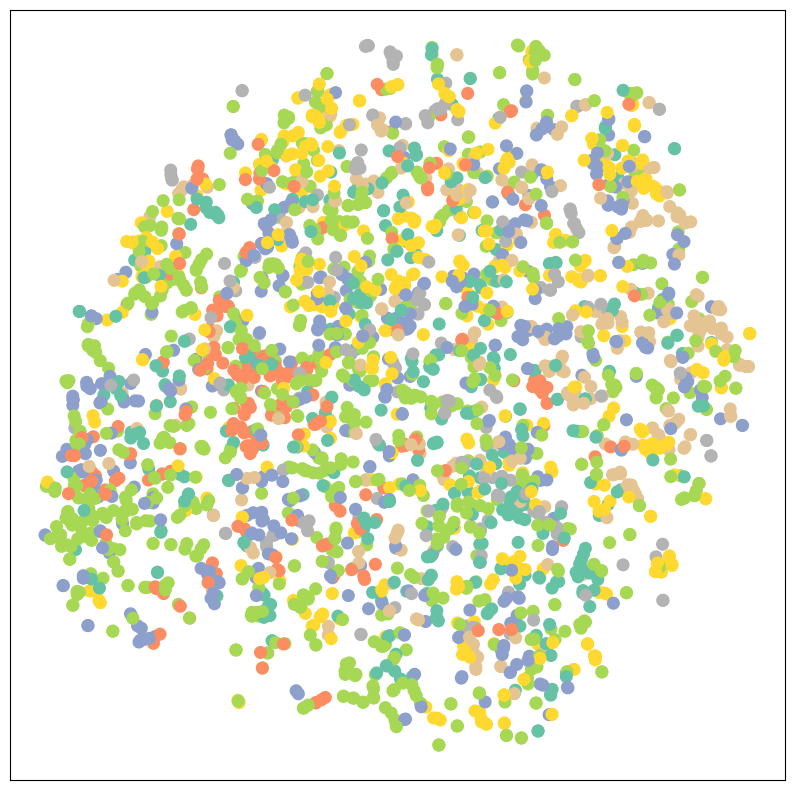

In [ ]:
model_gcn = GCN(
    hidden_channels=HIDDEN_CHANNELS_INPUT.value,
    num_layers=NUM_LAYERS_INPUT.value,
    num_features=dataset.num_features,
    num_classes=dataset.num_classes
)
model_gcn.eval()

out = model_gcn(data.x, data.edge_index)
visualize_TSNE(out, color=data.y)

MLP model


Epoch: 040, Loss: 1.3391


Epoch: 080, Loss: 0.6899


Epoch: 120, Loss: 0.5277


Epoch: 160, Loss: 0.4170


Epoch: 199, Loss: 0.4487
Test Accuracy: 0.5740
GCN model


Epoch: 040, Loss: 1.3972


Epoch: 080, Loss: 0.8277


Epoch: 120, Loss: 0.5309


Epoch: 160, Loss: 0.4715


Epoch: 199, Loss: 0.3978
Best Validation Loss: 0.8659
Best epoch: 198.0000
Test Accuracy: 0.8180


GAT model


Epoch: 040, Loss: 1.2481


Epoch: 080, Loss: 0.5586


Epoch: 120, Loss: 0.3297


Epoch: 160, Loss: 0.2867


Epoch: 199, Loss: 0.2400
Best Validation Loss: 0.7357
Best epoch: 198.0000
Test Accuracy: 0.8080


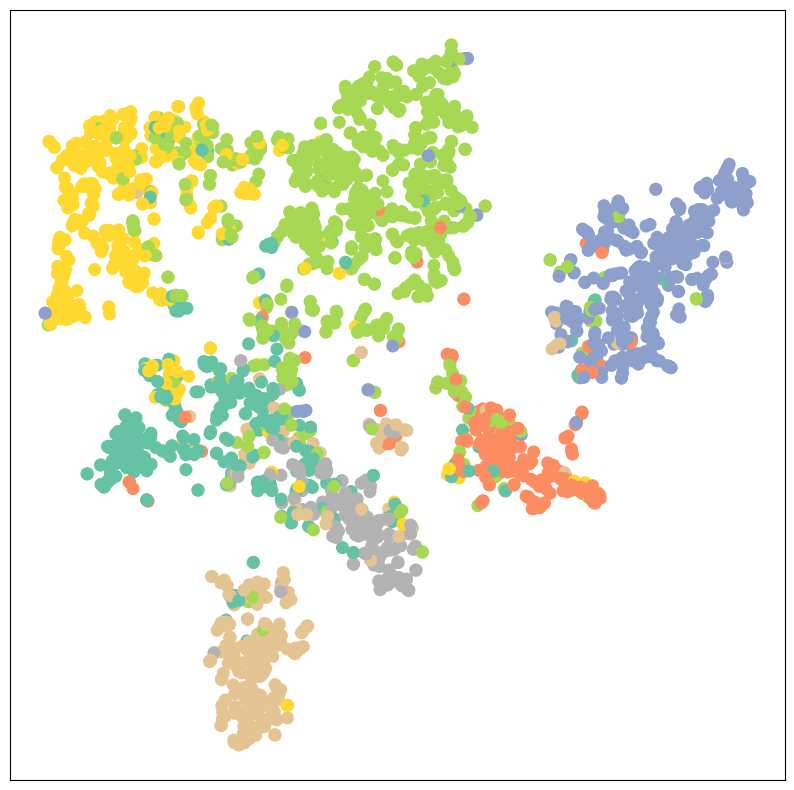

In [ ]:
print('MLP model')
model = MLP(hidden_channels=HIDDEN_CHANNELS_INPUT.value)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, NUMBER_EPOCHS_INPUT.value):
    loss = train()
    if epoch%40 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

print("="*20)
print('GCN model')
model_gcnn = GCN(
    hidden_channels=HIDDEN_CHANNELS_INPUT.value,
    num_layers=NUM_LAYERS_INPUT.value,
    num_features=dataset.num_features,
    num_classes=dataset.num_classes
)
optimizer = torch.optim.Adam(model_gcnn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

best_val_loss = float('inf')
best_model_state = None
best_epoch = None

def train():
    model_gcnn.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model_gcnn(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def evaluate():
    model_gcnn.eval()
    out = model_gcnn(data.x, data.edge_index)
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    val_pred = out[data.val_mask].argmax(dim=1)
    val_acc = (val_pred == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    return val_loss.item(), val_acc

def test():
      model_gcnn.eval()
      out = model_gcnn(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, NUMBER_EPOCHS_INPUT.value):
    loss = train()
    val_loss, val_acc = evaluate()

    if val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model_gcnn.state_dict())

    if epoch%40 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
# Load best model based on validation loss
model_gcnn.load_state_dict(best_model_state)

# Final test
test_acc = test()
print(f'Best Validation Loss: {best_val_loss:.4f}')
print(f'Best epoch: {best_epoch:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

print("="*20)
out_best_model = model_gcnn(data.x, data.edge_index)
visualize_TSNE(out_best_model, color=data.y)

print("="*20)
print('GAT model')
model_gat = GAT(hidden_channels=8, heads=8)

optimizer = torch.optim.Adam(model_gat.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

best_val_loss = float('inf')
best_model_state = None
best_epoch = None

def train():
    model_gat.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model_gat(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def evaluate():
    model_gat.eval()
    out = model_gat(data.x, data.edge_index)
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    val_pred = out[data.val_mask].argmax(dim=1)
    val_acc = (val_pred == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    return val_loss.item(), val_acc

def test():
      model_gat.eval()
      out = model_gat(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, NUMBER_EPOCHS_INPUT.value):
    loss = train()
    val_loss, val_acc = evaluate()

    if val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model_gat.state_dict())

    if epoch%40 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
# Load best model based on validation loss
model_gat.load_state_dict(best_model_state)

# Final test
test_acc = test()
print(f'Best Validation Loss: {best_val_loss:.4f}')
print(f'Best epoch: {best_epoch:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
out_best_model = model_gat(data.x, data.edge_index)
visualize_TSNE(out_best_model, color=data.y)